# Knn Algorithm Implementation Exploration


## Importing Data

`Pandas` was used to directly import and process the data from the CSV files. There's no need to generalize the data loading or ingest it into a database due to how small the dataset is. My computer at the very least was able to hold it in memory.

In [1]:
import numpy as np
import pandas as pd

train_inputs = pd.read_csv("../datasets/train_inputs.csv", header=None)
train_labels = pd.read_csv("../datasets/train_labels.csv", header=None)
test_inputs = pd.read_csv("../datasets/test_inputs.csv", header=None)
test_labels = pd.read_csv("../datasets/test_labels.csv", header=None)

train_inputs = train_inputs.rename(columns=lambda x: f"e{x+1}")
train_labels = train_labels.rename(columns={0: "category"})
test_inputs = test_inputs.rename(columns=lambda x: f"e{x+1}")
test_labels = test_labels.rename(columns={0: "category"})

## Implementing Knn Algorithm

My implementation of the K-Nearest Neighbour classification algorithm. The L3 norm was used for this implementation as it granted the most accuracy.

In [6]:
def k_nearest(target: np.ndarray, k: int, input_table: pd.DataFrame, labels: pd.DataFrame):
    """
    My implementation of the K-Nearest Neighbor classifier.

    :param target:
    :param k:
    :param input_table:
    :param labels:
    :return:
    """
    t_input_matrix = input_table.to_numpy()
    t_labels_matrix = labels.to_numpy().flat

    distance_label = np.zeros((len(input_table), 2), dtype="float")

    for row_index, (row, label) in enumerate(zip(t_input_matrix, t_labels_matrix)):
        distance = np.linalg.norm(target - row, ord=3)
        distance_label[row_index, 0] = distance
        distance_label[row_index, 1] = label

    labeled_distances = pd.DataFrame(data=distance_label, columns=["distance", "label"])
    labeled_distances.sort_values("distance", inplace=True)

    return labeled_distances["label"].iloc[:k].mode().iloc[0]


## Computing The Optimal Value of $k$

KFold validation was used here to compute the optimal value for $k$. Accuracy was determined by simply counting successful/failed classifications.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
result = next(kf.split(train_inputs), None)

split_training_inputs = train_inputs.iloc[result[0]]
split_training_labels = train_labels.iloc[result[0]]
split_test_inputs = train_inputs.iloc[result[1]]
split_test_labels = train_labels.iloc[result[1]]

results = []
accuracies = []

split_test_inputs_matrix = split_test_inputs.to_numpy()
split_test_labels_matrix = split_test_labels.to_numpy()

for n_neighbours in range(1, 31, 1):
    for vector, vector_label in zip(split_test_inputs_matrix, split_test_labels_matrix.flat):
        r = k_nearest(vector, n_neighbours, split_training_inputs, split_training_labels)
        results.append(float(r) == float(vector_label))

    accuracies.append((n_neighbours, results.count(True) / len(results)))
    results.clear()

## Graph!

A graph of the accuracy varying with $k$.

<Axes: xlabel='k', ylabel='Accuracy'>

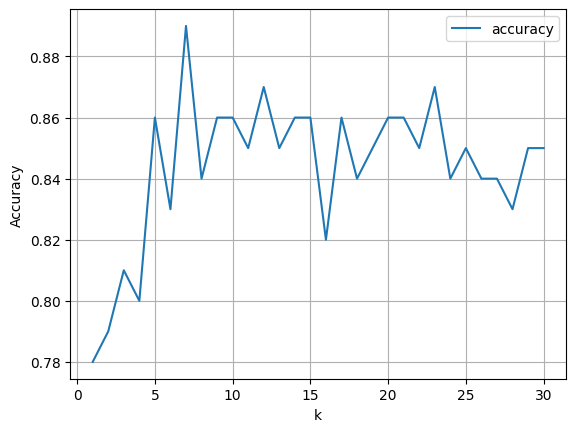

In [41]:
my_accuracies = pd.DataFrame(data=accuracies, columns=["k", "accuracy"])
my_accuracies.plot(kind="line", x="k", y="accuracy", grid=True, ylabel="Accuracy")

## Extract Best Value For $k$

The $k$'s are sorted by which gives the highest accuracy, and the best one is stored.

In [34]:
# The result is converted to int since pandas returns k as a float for no reason.
max_accuracy = int(my_accuracies.sort_values(by="accuracy", ascending=False).iloc[0].k)

## Cross Validation Accuracy

The accuracy is tested again with a new 10-fold cross validation split.

In [45]:
kf = KFold(n_splits=10, shuffle=True)
result = next(kf.split(train_inputs), None)

split_training_inputs = train_inputs.iloc[result[0]]
split_training_labels = train_labels.iloc[result[0]]
split_test_inputs = train_inputs.iloc[result[1]]
split_test_labels = train_labels.iloc[result[1]]

results = []

for vector, vector_label in zip(split_test_inputs_matrix, split_test_labels_matrix.flat):
    r = k_nearest(vector, max_accuracy, split_training_inputs, split_training_labels)
    results.append(float(r) == float(vector_label))

print(f"Best K value: {max_accuracy}")
print(f"Cross-validation accuracy: {results.count(True) / len(results)}")

Best K value: 7
Cross-validation accuracy: 0.91


## Test Accuracy

Test accuracy is computed using the best value for $k$.

In [43]:
test_input_matrix = test_inputs.to_numpy()
test_labels_matrix = test_labels.to_numpy().flat

rs = []

for (test_row, test_label) in zip(test_input_matrix, test_labels_matrix):
    r = k_nearest(test_row, max_accuracy, test_inputs, test_labels)
    rs.append(r == test_label)

test_accuracy = sum(rs) / len(rs)

print(f"Accuracy on test set: {test_accuracy}")

Accuracy on test set: 0.8090909090909091
